# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast


## <span style='color:#ff5f27'> 📝 Imports


In [1]:
import sys
from pathlib import Path
import os


def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False


def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book


def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir)
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")

# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config

if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: c:\Users\dtanu\Documents\RAJAN_TANUDIN-mlfs-book
HopsworksSettings initialized!
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days=1)
today

datetime.datetime(2025, 11, 18, 22, 11, 48, 448886)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>


In [4]:
project = hopsworks.login()
fs = project.get_feature_store()

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country = location['country']
city = location['city']
street = location['street']

2025-11-18 22:11:48,512 INFO: Initializing external client
2025-11-18 22:11:48,513 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 22:11:48,513 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 22:11:49,135 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'

2025-11-18 22:11:49,135 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 22:11:48,512 INFO: Initializing external client
2025-11-18 22:11:48,513 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 22:11:48,513 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 22:11:49,135 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'

2025-11-18 22:11:49,135 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 22:11:48,512 INFO: Initializing external client
2025-11-18 22:11:48,513 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 22:11:48,513 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 22:11:49,135 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'

2025-11-18 22:11:49,135 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 22:11:50,397 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1303708

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1303708


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>


In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 22:11:52,620 INFO: There is no parent information


2025-11-18 22:11:52,620 INFO: There is no parent information


Downloading: 0.000%|          | 0/525653 elapsed<00:00 remaining<?

2025-11-18 22:11:52,620 INFO: There is no parent information


Downloading: 0.000%|          | 0/525653 elapsed<00:00 remaining<?

2025-11-18 22:11:52,620 INFO: There is no parent information


Downloading: 0.000%|          | 0/525653 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/84407 elapsed<00:00 remaining<?

2025-11-18 22:11:52,620 INFO: There is no parent information


Downloading: 0.000%|          | 0/525653 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/84407 elapsed<00:00 remaining<?

2025-11-18 22:11:52,620 INFO: There is no parent information


Downloading: 0.000%|          | 0/525653 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/84407 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/86628 elapsed<00:00 remaining<?

2025-11-18 22:11:52,620 INFO: There is no parent information


Downloading: 0.000%|          | 0/525653 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/84407 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/86628 elapsed<00:00 remaining<?

2025-11-18 22:11:52,620 INFO: There is no parent information


Downloading: 0.000%|          | 0/525653 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/84407 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/86628 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/22548 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.5142857E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View </span>


In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-19 00:00:00+00:00,9.40,0.0,5.052841,175.914459,San Francisco
1,2025-11-23 00:00:00+00:00,8.40,0.0,0.720000,180.000000,San Francisco
2,2025-11-22 00:00:00+00:00,9.60,0.0,0.360000,90.000000,San Francisco
3,2025-11-24 00:00:00+00:00,10.05,0.0,1.138420,288.435028,San Francisco
4,2025-11-20 00:00:00+00:00,10.80,0.8,4.104631,164.744827,San Francisco
5,2025-11-21 00:00:00+00:00,9.05,0.0,0.509117,224.999893,San Francisco


## <span style="color:#ff5f27;">🔄 Get Lagged PM2.5 Features from Feature Store</span>

To make predictions, we need the PM2.5 values from the previous 3 days as features.

In [8]:
# Get air quality feature group to fetch historical PM2.5 values
air_quality_fg = fs.get_feature_group(name="air_quality", version=1)

# We need the last 3 days of PM2.5 data to create lagged features
yesterday = today - datetime.timedelta(days=1)
two_days_ago = today - datetime.timedelta(days=2)
three_days_ago = today - datetime.timedelta(days=3)

# Fetch historical PM2.5 values
query = air_quality_fg.select(['date', 'pm25']).filter(
    (air_quality_fg.country == country) & 
    (air_quality_fg.city == city) & 
    (air_quality_fg.street == street) &
    (air_quality_fg.date >= three_days_ago) &
    (air_quality_fg.date < today)
)

historical_aq_df = query.read()
historical_aq_df = historical_aq_df.sort_values('date')

print(f"Historical PM2.5 data for lagged features:")
print(historical_aq_df)

# Extract lagged values
if len(historical_aq_df) >= 3:
    pm25_lag1 = historical_aq_df[historical_aq_df['date'] == pd.Timestamp(yesterday).normalize()]['pm25'].values
    pm25_lag2 = historical_aq_df[historical_aq_df['date'] == pd.Timestamp(two_days_ago).normalize()]['pm25'].values
    pm25_lag3 = historical_aq_df[historical_aq_df['date'] == pd.Timestamp(three_days_ago).normalize()]['pm25'].values
    
    print(f"\nLagged features for prediction:")
    print(f"PM2.5 lag1 (yesterday): {pm25_lag1[0] if len(pm25_lag1) > 0 else 'N/A'}")
    print(f"PM2.5 lag2 (2 days ago): {pm25_lag2[0] if len(pm25_lag2) > 0 else 'N/A'}")
    print(f"PM2.5 lag3 (3 days ago): {pm25_lag3[0] if len(pm25_lag3) > 0 else 'N/A'}")
else:
    print(f"Warning: Not enough historical data. Found {len(historical_aq_df)} days, need 3.")
    pm25_lag1 = pm25_lag2 = pm25_lag3 = [None]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.54s) 
Historical PM2.5 data for lagged features:
                       date   pm25
0 2025-11-16 00:00:00+00:00   2.94
2 2025-11-17 00:00:00+00:00   2.52
1 2025-11-18 00:00:00+00:00  13.00

Lagged features for prediction:
PM2.5 lag1 (yesterday): N/A
PM2.5 lag2 (2 days ago): N/A
PM2.5 lag3 (3 days ago): N/A
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.54s) 
Historical PM2.5 data for lagged features:
                       date   pm25
0 2025-11-16 00:00:00+00:00   2.94
2 2025-11-17 00:00:00+00:00   2.52
1 2025-11-18 00:00:00+00:00  13.00

Lagged features for prediction:
PM2.5 lag1 (yesterday): N/A
PM2.5 lag2 (2 days ago): N/A
PM2.5 lag3 (3 days ago): N/A


### <span style="color:#ff5f27;">🤖 Making the predictions</span>


In [9]:
# Add lagged features to batch data - ensure they are float type
batch_data['pm25_lag1'] = float(pm25_lag1[0]) if len(pm25_lag1) > 0 and pm25_lag1[0] is not None else 0.0
batch_data['pm25_lag2'] = float(pm25_lag2[0]) if len(pm25_lag2) > 0 and pm25_lag2[0] is not None else 0.0
batch_data['pm25_lag3'] = float(pm25_lag3[0]) if len(pm25_lag3) > 0 and pm25_lag3[0] is not None else 0.0

print(f"\nAdded lagged features to batch data:")
print(f"pm25_lag1: {batch_data['pm25_lag1'].iloc[0]} (type: {batch_data['pm25_lag1'].dtype})")
print(f"pm25_lag2: {batch_data['pm25_lag2'].iloc[0]} (type: {batch_data['pm25_lag2'].dtype})")
print(f"pm25_lag3: {batch_data['pm25_lag3'].iloc[0]} (type: {batch_data['pm25_lag3'].dtype})")

# Make predictions with all features (weather + lagged PM2.5)
# IMPORTANT: Feature order must match the training order!
# The model was trained with lagged features first, then weather features
feature_columns = [
    'pm25_lag1',
    'pm25_lag2',
    'pm25_lag3',
    'temperature_2m_mean', 
    'precipitation_sum', 
    'wind_speed_10m_max', 
    'wind_direction_10m_dominant'
]

batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(batch_data[feature_columns])
batch_data


Added lagged features to batch data:
pm25_lag1: 0.0 (type: float64)
pm25_lag2: 0.0 (type: float64)
pm25_lag3: 0.0 (type: float64)


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25
0,2025-11-19 00:00:00+00:00,9.40,0.0,5.052841,175.914459,San Francisco,0.0,0.0,0.0,17.092955
1,2025-11-23 00:00:00+00:00,8.40,0.0,0.720000,180.000000,San Francisco,0.0,0.0,0.0,17.544329
2,2025-11-22 00:00:00+00:00,9.60,0.0,0.360000,90.000000,San Francisco,0.0,0.0,0.0,17.661081
3,2025-11-24 00:00:00+00:00,10.05,0.0,1.138420,288.435028,San Francisco,0.0,0.0,0.0,16.428799
4,2025-11-20 00:00:00+00:00,10.80,0.8,4.104631,164.744827,San Francisco,0.0,0.0,0.0,16.154127
5,2025-11-21 00:00:00+00:00,9.05,0.0,0.509117,224.999893,San Francisco,0.0,0.0,0.0,17.582420


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag1                    6 non-null      float64                
 7   pm25_lag2                    6 non-null      float64                
 8   pm25_lag3                    6 non-null      float64                
 9   predicted_pm25               6 non-null      float32                
dtypes: dat

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>


In [11]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data) + 1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,9.40,0.0,5.052841,175.914459,San Francisco,0.0,0.0,0.0,17.092955,1600 Divisadero Street,United States,1
4,2025-11-20 00:00:00+00:00,10.80,0.8,4.104631,164.744827,San Francisco,0.0,0.0,0.0,16.154127,1600 Divisadero Street,United States,5
5,2025-11-21 00:00:00+00:00,9.05,0.0,0.509117,224.999893,San Francisco,0.0,0.0,0.0,17.582420,1600 Divisadero Street,United States,6
2,2025-11-22 00:00:00+00:00,9.60,0.0,0.360000,90.000000,San Francisco,0.0,0.0,0.0,17.661081,1600 Divisadero Street,United States,3
1,2025-11-23 00:00:00+00:00,8.40,0.0,0.720000,180.000000,San Francisco,0.0,0.0,0.0,17.544329,1600 Divisadero Street,United States,2
3,2025-11-24 00:00:00+00:00,10.05,0.0,1.138420,288.435028,San Francisco,0.0,0.0,0.0,16.428799,1600 Divisadero Street,United States,4


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 0 to 3
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag1                    6 non-null      float64                
 7   pm25_lag2                    6 non-null      float64                
 8   pm25_lag3                    6 non-null      float64                
 9   predicted_pm25               6 non-null      float32                
 10  street     

### Create Forecast Graph

Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages


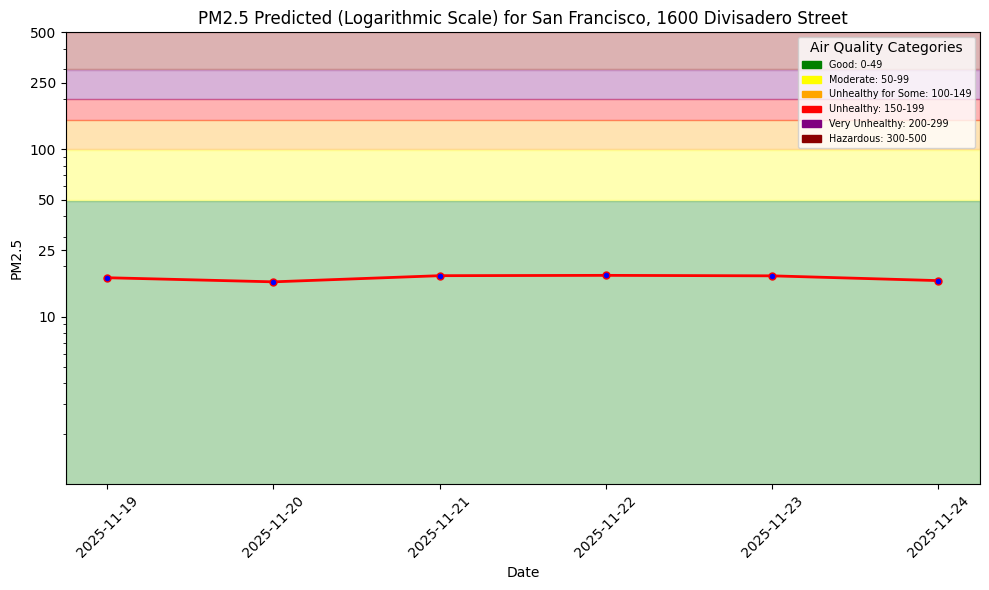

In [13]:
pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [17]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city', 'street', 'date', 'days_before_forecast_day'],
    event_time="date",
)

### ⚠️ Delete Old Monitoring Feature Group

The monitoring feature group needs to include lagged features in its schema. If you created it before adding lagged features, we need to delete and recreate it.

In [18]:
# Delete the old aq_predictions feature group if it exists
# This is necessary when adding lagged features to the schema
try:
    old_monitor_fg = fs.get_feature_group(name='aq_predictions', version=1)
    old_monitor_fg.delete()
    print("✅ Deleted old 'aq_predictions' feature group (version 1)")
except Exception as e:
    print(f"ℹ️ No existing 'aq_predictions' feature group to delete (or already deleted): {e}")

ℹ️ No existing 'aq_predictions' feature group to delete (or already deleted): 'NoneType' object has no attribute 'delete'


In [19]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1303708/fs/1291338/fg/1719064


Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1303708/fs/1291338/fg/1719064


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00



Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1303708/fs/1291338/fg/1719064


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00



Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1303708/jobs/named/aq_predictions_1_offline_fg_materialization/executions
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1303708/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 22:14:19,997 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 22:14:19,997 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 22:14:26,425 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 22:14:26,425 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 22:16:14,760 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 22:16:14,931 INFO: Waiting for l

(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [20]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,9.4,0.0,5.052841,175.914459,San Francisco,0.0,0.0,0.0,17.092955,1600 Divisadero Street,United States,1


In [21]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 


,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3
0,2025-07-26 00:00:00+00:00,2.50,United States,San Francisco,1600 Divisadero Street,https://api.waqi.info/feed/A399343,2.38,2.57,2.54
1,2023-06-22 00:00:00+00:00,4.70,United States,San Francisco,1600 Divisadero Street,https://api.waqi.info/feed/A399343,4.66,3.06,3.20
2,2023-10-14 00:00:00+00:00,4.48,United States,San Francisco,1600 Divisadero Street,https://api.waqi.info/feed/A399343,4.50,5.87,5.01
3,2023-11-04 00:00:00+00:00,2.45,United States,San Francisco,1600 Divisadero Street,https://api.waqi.info/feed/A399343,10.50,9.43,8.91
4,2024-07-30 00:00:00+00:00,1.96,United States,San Francisco,1600 Divisadero Street,https://api.waqi.info/feed/A399343,2.77,4.97,4.63
...,...,...,...,...,...,...,...,...,...
886,2025-02-03 00:00:00+00:00,2.84,United States,San Francisco,1600 Divisadero Street,https://api.waqi.info/feed/A399343,2.97,6.35,7.40
887,2024-02-12 00:00:00+00:00,7.04,United States,San Francisco,1600 Divisadero Street,https://api.waqi.info/feed/A399343,2.54,2.74,4.05
888,2025-10-07 00:00:00+00:00,5.68,United States,San Francisco,1600 Divisadero Street,https://api.waqi.info/feed/A399343,5.76,5.50,5.09
889,2025-11-17 00:00:00+00:00,2.52,United States,San Francisco,1600 Divisadero Street,https://api.waqi.info/feed/A399343,2.94,3.87,3.67


### Custom Backfill Function for Lagged Features

The shared `util.backfill_predictions_for_monitoring()` function doesn't support lagged features. We'll define a custom version here that includes them.

In [ ]:
def backfill_predictions_with_lags(weather_fg, air_quality_df, monitor_fg, model):
    """
    Custom backfill function that includes lagged PM2.5 features.
    This overrides the util.backfill_predictions_for_monitoring() function
    to support models trained with lagged features.
    """
    # Get weather features
    features_df = weather_fg.read()
    features_df = features_df.sort_values(by=['date'], ascending=True)
    features_df = features_df.tail(10)
    
    # Add lagged features for each row
    predictions = []
    for idx, row in features_df.iterrows():
        current_date = row['date']
        
        # Get historical PM2.5 values for lagged features
        yesterday = current_date - pd.Timedelta(days=1)
        two_days_ago = current_date - pd.Timedelta(days=2)
        three_days_ago = current_date - pd.Timedelta(days=3)
        
        # Try to get lagged values from air_quality_df
        pm25_lag1 = air_quality_df[air_quality_df['date'] == yesterday]['pm25'].values
        pm25_lag2 = air_quality_df[air_quality_df['date'] == two_days_ago]['pm25'].values
        pm25_lag3 = air_quality_df[air_quality_df['date'] == three_days_ago]['pm25'].values
        
        # Use actual values if available, otherwise use 0.0
        lag1 = float(pm25_lag1[0]) if len(pm25_lag1) > 0 else 0.0
        lag2 = float(pm25_lag2[0]) if len(pm25_lag2) > 0 else 0.0
        lag3 = float(pm25_lag3[0]) if len(pm25_lag3) > 0 else 0.0
        
        # Create feature vector in the correct order
        feature_vector = pd.DataFrame([[
            lag1, lag2, lag3,
            row['temperature_2m_mean'],
            row['precipitation_sum'],
            row['wind_speed_10m_max'],
            row['wind_direction_10m_dominant']
        ]], columns=[
            'pm25_lag1', 'pm25_lag2', 'pm25_lag3',
            'temperature_2m_mean', 'precipitation_sum',
            'wind_speed_10m_max', 'wind_direction_10m_dominant'
        ])
        
        # Make prediction
        pred = model.predict(feature_vector)[0]
        predictions.append(pred)
    
    # Add predictions and lagged features to features_df BEFORE merging
    features_df['predicted_pm25'] = predictions
    
    # Add lagged features based on the index position in features_df
    features_df['pm25_lag1'] = [predictions[i-1] if i > 0 else 0.0 for i in range(len(predictions))]
    features_df['pm25_lag2'] = [predictions[i-2] if i > 1 else 0.0 for i in range(len(predictions))]
    features_df['pm25_lag3'] = [predictions[i-3] if i > 2 else 0.0 for i in range(len(predictions))]
    
    # Merge with actual air quality data
    df = pd.merge(features_df, air_quality_df[['date','pm25','street','country']], on="date")
    df['days_before_forecast_day'] = 1
    df['city'] = city
    
    # Prepare data for monitoring feature group (exclude 'pm25' actual values)
    # The monitoring feature group only stores predictions and metadata, not actual values
    monitoring_cols = ['date', 'city', 'street', 'country', 'days_before_forecast_day', 
                       'predicted_pm25', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3',
                       'temperature_2m_mean', 'precipitation_sum', 
                       'wind_speed_10m_max', 'wind_direction_10m_dominant']
    
    # Insert into monitoring feature group
    monitor_fg.insert(df[monitoring_cols], write_options={"wait_for_job": False})
    
    return df[['date', 'predicted_pm25', 'pm25']]

print("Custom backfill function defined with lagged features support")

✅ Custom backfill function defined with lagged features support


In [23]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df = monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    # Use our custom backfill function that supports lagged features
    hindcast_df = backfill_predictions_with_lags(
        weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model
    )
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 


Uploading Dataframe: 100.00% |██████████| Rows 4/4 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1303708/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,predicted_pm25,pm25
0,2025-11-15 00:00:00+00:00,12.809898,3.87
1,2025-11-16 00:00:00+00:00,18.994570,2.94
2,2025-11-17 00:00:00+00:00,14.383299,2.52
3,2025-11-18 00:00:00+00:00,17.544329,13.00


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

**This graph will be empty to begin with - this is normal.**

After a few days of predictions and observations, you will get data points in this graph.


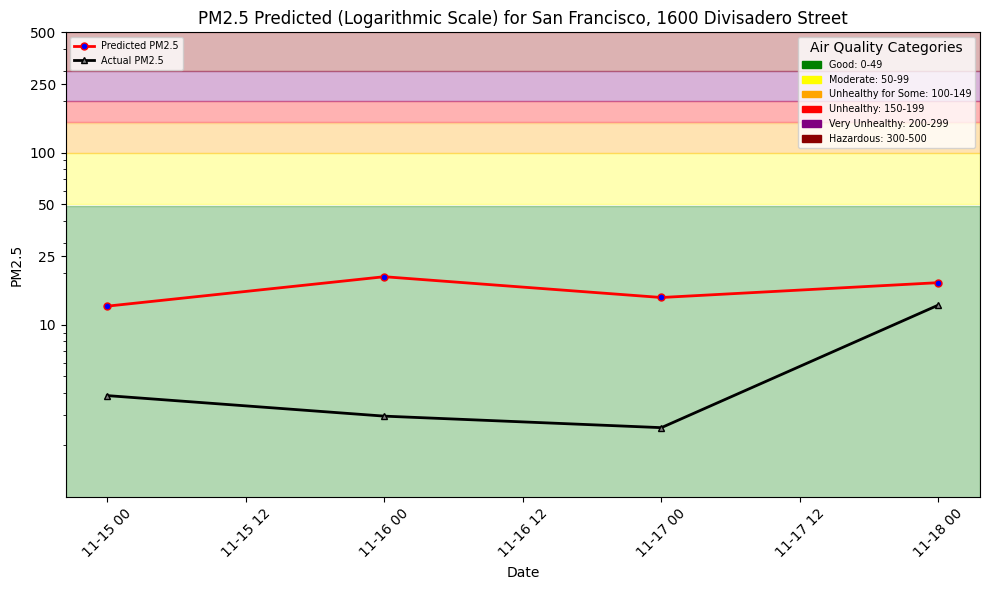

In [24]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [25]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading c:\Users\dtanu\Documents\RAJAN_TANUDIN-mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.00…

Uploading c:\Users\dtanu\Documents\RAJAN_TANUDIN-mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png:…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1303708/settings/fb/path/Resources/airquality


---
